# Temporal Graph Neural Network - Dynamic Causal Relationships Across Assets

Architecture:  
- Temporal Graph Neural Network with learned, time-varying adjacency matrices  
- Multi-head attention over edges (attention weight ≈ influence strength)  
- L1 sparsity constraints to avoid spurious edges  
- GRU encoder for temporal dynamics  

Assets covered: 11 Equity Sector ETFs + 6 Commodity ETFs + 8 FX rates  
Data: Real market data via `yfinance`  

## 1. Imports & Configuration

In [30]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import networkx as nx
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
import itertools

# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

# ── Plot style ────────────────────────────────────────────────────────────────
plt.style.use('dark_background')
ACCENT   = '#00FFB2'   # green
ACCENT2  = '#FF6B6B'   # blue
ACCENT3  = '#FFD93D'   # amber
BG       = '#0D0D0D'
PANEL    = '#1A1A2E'

sns.set_palette('husl')
print('Setup complete')

Device: cpu
Setup complete


## 2. Asset Universe & Real Data Download

In [5]:
# ── Asset universe ────────────────────────────────────────────────────────────
ASSETS = {
    # Equity sector ETFs
    'XLK':  ('Technology',        'equity'),
    'XLF':  ('Financials',        'equity'),
    'XLE':  ('Energy',            'equity'),
    'XLV':  ('Healthcare',        'equity'),
    'XLI':  ('Industrials',       'equity'),
    'XLB':  ('Materials',         'equity'),
    'XLU':  ('Utilities',         'equity'),
    'XLRE': ('Real Estate',       'equity'),
    'XLC':  ('Comm Services',     'equity'),
    'XLP':  ('Cons Staples',      'equity'),
    'XLY':  ('Cons Discretionary','equity'),
    # Commodity ETFs
    'GLD':  ('Gold',              'commodity'),
    'SLV':  ('Silver',            'commodity'),
    'USO':  ('Oil (WTI)',         'commodity'),
    'DBA':  ('Agriculture',       'commodity'),
    'PDBC': ('Broad Commodities', 'commodity'),
    'CPER': ('Copper',            'commodity'),
    # FX (expressed as USD per unit of foreign currency via ETFs/pairs)
    'FXE':  ('EUR/USD',           'fx'),
    'FXY':  ('JPY/USD',           'fx'),
    'FXB':  ('GBP/USD',           'fx'),
    'FXC':  ('CAD/USD',           'fx'),
    'FXA':  ('AUD/USD',           'fx'),
    'FXF':  ('CHF/USD',           'fx'),
    'CYB':  ('CNY/USD',           'fx'),
    'BZF':  ('BRL/USD',           'fx'),
}

TICKERS   = list(ASSETS.keys())
N_ASSETS  = len(TICKERS)
NAMES     = [v[0] for v in ASSETS.values()]
ASSET_TYPE = np.array([v[1] for v in ASSETS.values()])

print(f'Total assets : {N_ASSETS}')
print(f'  Equity     : {(ASSET_TYPE=="equity").sum()}')
print(f'  Commodity  : {(ASSET_TYPE=="commodity").sum()}')
print(f'  FX         : {(ASSET_TYPE=="fx").sum()}')

Total assets : 25
  Equity     : 11
  Commodity  : 6
  FX         : 8


In [8]:
# ── Download price data ───────────────────────────────────────────────────────
START_DATE = '2018-01-01'
END_DATE   = '2024-12-31'

print(f'Downloading {N_ASSETS} tickers from {START_DATE} → {END_DATE} ...')
raw = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    progress=True,
    auto_adjust=True
)['Close']

# Keep only tickers that actually downloaded
available = [t for t in TICKERS if t in raw.columns]
# Drop assets with no data at all
valid_assets = [c for c in raw.columns if raw[c].notna().sum() > 0]
raw = raw[valid_assets]

prices = (raw.ffill().dropna())

print(f'\nPrice data shape : {prices.shape}  ({prices.index[0].date()} → {prices.index[-1].date()})')
prices.head(3)

[*********************100%***********************]  25 of 25 completed

1 Failed download:
['BZF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2024-12-31)')



Price data shape : (1644, 24)  (2018-06-19 → 2024-12-30)


Ticker,CPER,CYB,DBA,FXA,FXB,FXC,FXE,FXF,FXY,GLD,...,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,19.35,26.075020,15.558637,70.116959,117.052757,69.710709,105.879677,94.270714,87.010002,120.800003,...,46.472141,26.737791,23.704649,64.433464,33.221363,41.704506,24.398003,19.823650,74.649933,52.020679
2018-06-20,19.33,26.055496,15.627402,70.040977,117.116844,69.541817,105.889168,94.170769,86.739998,120.260002,...,47.048851,26.855850,23.643976,64.477448,33.291115,41.745335,24.661346,19.839443,74.808281,52.267323
2018-06-21,19.26,25.918823,15.584424,70.221558,117.647758,69.607498,106.165451,94.680511,87.050003,120.050003,...,46.760494,26.358585,23.574642,63.667973,33.035320,41.827007,24.808510,19.906597,74.377243,51.895023


## 3. Feature Engineering

In [9]:
def build_features(prices: pd.DataFrame) -> pd.DataFrame:
    """Per-asset features stacked into a MultiIndex DataFrame."""
    feats = {}
    for t in prices.columns:
        p = prices[t]
        r1  = p.pct_change(1)          # 1-day return
        r5  = p.pct_change(5)          # 5-day return
        r21 = p.pct_change(21)         # 21-day return
        vol5  = r1.rolling(5).std()    # 5-day realised vol
        vol21 = r1.rolling(21).std()   # 21-day realised vol
        mom5  = r1.rolling(5).mean()   # 5-day momentum
        rsi   = _rsi(p, 14)            # RSI-14
        zscore= (p - p.rolling(63).mean()) / p.rolling(63).std()  # 63d z-score
        feats[t] = pd.DataFrame({
            'ret1': r1, 'ret5': r5, 'ret21': r21,
            'vol5': vol5, 'vol21': vol21,
            'mom5': mom5, 'rsi': rsi, 'zscore': zscore
        })
    return pd.concat(feats, axis=1)  # columns: (ticker, feature)

def _rsi(series, period=14):
    delta = series.diff()
    gain  = delta.clip(lower=0).rolling(period).mean()
    loss  = (-delta.clip(upper=0)).rolling(period).mean()
    rs    = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))

feat_df = build_features(prices)
feat_df.dropna(inplace=True)

# Target: next-day return for each asset
ret_df = prices.pct_change(1).shift(-1)  # forward 1-day return

# Align
common_idx = feat_df.index.intersection(ret_df.dropna().index)
feat_df = feat_df.loc[common_idx]
ret_df  = ret_df.loc[common_idx]

N_FEATS = feat_df.shape[1] // N_ASSETS
print(f'Features per asset : {N_FEATS}')
print(f'Training dates     : {len(common_idx)}  ({common_idx[0].date()} → {common_idx[-1].date()})')

Features per asset : 7
Training dates     : 1344  (2018-09-17 → 2024-01-19)


In [26]:
# ── Normalise per asset / feature using expanding window to avoid lookahead ───
TRAIN_SPLIT = 0.70
VAL_SPLIT   = 0.15   # remaining = test

asset_cols = infer_asset_blocks(feat_df.columns)

def infer_asset_blocks(columns):
    """
    Supports:
    - MultiIndex columns: (asset, feature)
    - Flat columns: 'ASSET_feature'
    """
    asset_map = {}

    if isinstance(columns, pd.MultiIndex):
        for asset, feat in columns:
            asset_map.setdefault(asset, []).append((asset, feat))
    else:
        for c in columns:
            asset, feat = c.split('_', 1)
            asset_map.setdefault(asset, []).append(c)

    return asset_map



# ------------------------------------------------------------------
# Scale per asset (causality-safe)
# ------------------------------------------------------------------

def scale_and_reshape(feat_df, asset_cols, n_tr):
    T = len(feat_df)
    N = len(asset_cols)
    L = len(next(iter(asset_cols.values())))

    feat_3d = np.zeros((T, N, L), dtype=np.float32)
    scalers = {}

    for i, asset in enumerate(sorted(asset_cols)):
        cols = asset_cols[asset]
        block = feat_df[cols].values.astype(np.float32)

        scaler = StandardScaler()
        block[:n_tr] = scaler.fit_transform(block[:n_tr])
        block[n_tr:] = scaler.transform(block[n_tr:])

        feat_3d[:, i, :] = block
        scalers[asset] = scaler

    return feat_3d, scalers


feat_3d, scalers = scale_and_reshape(feat_df, asset_cols, n_tr)
assets = sorted(asset_cols.keys())
ret_arr = ret_df[assets].values.astype(np.float32)

print(f"feat_3d : {feat_3d.shape}   (T, N_assets, N_feats)")
print(f"ret_arr : {ret_arr.shape}   (T, N_assets)")
print(f"Train / Val / Test split: {n_tr} / {n_val-n_tr} / {T-n_val} days")

feat_3d : (1344, 24, 8)   (T, N_assets, N_feats)
ret_arr : (1344, 24)   (T, N_assets)
Train / Val / Test split: 940 / 202 / 202 days


## 4. Dataset

In [27]:
SEQ_LEN   = 20   # lookback window (trading days)
PRED_STEP = 1    # predict 1-day-ahead

class AssetGraphDataset(Dataset):
    """
    Each sample: (X, y)
      X : [SEQ_LEN, N_ASSETS, N_FEATS]  — input feature sequence
      y : [N_ASSETS]                    — next-day returns
    """
    def __init__(self, feat_3d, ret_arr, indices):
        self.feat = torch.tensor(feat_3d, dtype=torch.float32)
        self.ret  = torch.tensor(ret_arr, dtype=torch.float32)
        # Only use indices where full lookback is available
        self.idx  = [i for i in indices if i >= SEQ_LEN]

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, k):
        t  = self.idx[k]
        X  = self.feat[t - SEQ_LEN : t]   # [SEQ_LEN, N, F]
        y  = self.ret[t]                   # [N]
        return X, y

train_idx = list(range(SEQ_LEN, n_tr))
val_idx   = list(range(n_tr,   n_val))
test_idx  = list(range(n_val,  n))

train_ds = AssetGraphDataset(feat_3d, ret_arr, train_idx)
val_ds   = AssetGraphDataset(feat_3d, ret_arr, val_idx)
test_ds  = AssetGraphDataset(feat_3d, ret_arr, test_idx)

BATCH = 32
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

print(f'Train batches: {len(train_dl)}  |  Val: {len(val_dl)}  |  Test: {len(test_dl)}')

Train batches: 28  |  Val: 7  |  Test: 7


## 5. Model Architecture - TGNN with Attention & Sparsity

In [28]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 1: Temporal Encoder — per-asset GRU that summarises the lookback window
# ─────────────────────────────────────────────────────────────────────────────
class TemporalEncoder(nn.Module):
    """
    GRU applied independently per asset over the time dimension.
    Input : [B, T, N, L]
    Output: [B, N, H]   (final hidden state per asset)
    """
    def __init__(self, in_features, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=8, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        # x: [B, T, N, L]
        B, T, N, L = x.shape
        # Merge batch & asset dims for parallel GRU processing
        x2   = x.permute(0, 2, 1, 3).reshape(B * N, T, L)  # [B*N, T, L]
        _, h = self.gru(x2)                                  # h: [layers, B*N, H]
        h    = h[-1].reshape(B, N, self.hidden_size)         # [B, N, H]
        return h


# ─────────────────────────────────────────────────────────────────────────────
# Block 2: Multi-Head Graph Attention — learns the causal adjacency matrix A_t
# ─────────────────────────────────────────────────────────────────────────────
class GraphAttentionLayer(nn.Module):
    """
    Computes a directed, sparse attention-weighted adjacency matrix A ∈ [B, N, N].
    A_ij = attention from j → i  (edge weight = 'how much does j explain i?')

    Sparsity: L1 penalty on A (applied during training outside this module).
    """
    def __init__(self, hidden_size, n_heads=4, dropout=0.1):
        super().__init__()
        assert hidden_size % n_heads == 0
        self.n_heads = n_heads
        self.d_head  = hidden_size // n_heads

        self.W_q = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)
        self.out  = nn.Linear(hidden_size, hidden_size)
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size)

        # Learnable threshold bias for sparsity control
        self.sparsity_bias = nn.Parameter(torch.zeros(1))

    def forward(self, h):
        # h: [B, N, H]
        B, N, H = h.shape
        nh = self.n_heads
        dh = self.d_head

        Q = self.W_q(h).view(B, N, nh, dh).permute(0, 2, 1, 3)  # [B, nh, N, dh]
        K = self.W_k(h).view(B, N, nh, dh).permute(0, 2, 1, 3)
        V = self.W_v(h).view(B, N, nh, dh).permute(0, 2, 1, 3)

        # Scaled dot-product attention → [B, nh, N, N]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (dh ** 0.5)
        scores = scores + self.sparsity_bias           # learnable offset

        # Soft attention (use sigmoid so each edge is independent — better for sparsity)
        attn = torch.sigmoid(scores)                   # [B, nh, N, N]  ∈ [0,1]
        attn = self.drop(attn)

        # Aggregate: h'_i = sum_j A_ij * V_j
        out = torch.matmul(attn, V)                    # [B, nh, N, dh]
        out = out.permute(0, 2, 1, 3).reshape(B, N, H)
        out = self.norm(self.out(out) + h)             # residual

        # Return mean adjacency across heads for interpretability
        A = attn.mean(dim=1)                           # [B, N, N]
        return out, A


# ─────────────────────────────────────────────────────────────────────────────
# Block 3: Graph Propagation — stacked graph conv steps
# ─────────────────────────────────────────────────────────────────────────────
class GraphConvLayer(nn.Module):
    """Single graph conv: h' = ReLU( A @ h @ W )"""
    def __init__(self, hidden_size):
        super().__init__()
        self.W    = nn.Linear(hidden_size, hidden_size)
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, h, A):
        # h: [B, N, H],  A: [B, N, N]
        agg = torch.bmm(A, h)             # [B, N, H]
        out = F.relu(self.W(agg))
        return self.norm(out + h)


# ─────────────────────────────────────────────────────────────────────────────
# Full TGNN model
# ─────────────────────────────────────────────────────────────────────────────
class TemporalCausalGNN(nn.Module):
    """
    Full model:
      1. TemporalEncoder  → per-asset hidden state
      2. GraphAttentionLayer → dynamic adjacency A_t + enriched embeddings
      3. GraphConvLayer ×2  → message passing over learned graph
      4. MLP head           → predict next-day return per asset
    """
    def __init__(self, n_assets, n_feats, hidden=64, n_heads=4,
                 n_gconv=2, gru_layers=2, dropout=0.15):
        super().__init__()
        self.n_assets = n_assets
        self.temporal = TemporalEncoder(n_feats, hidden, num_layers=gru_layers, dropout=dropout)
        self.attn     = GraphAttentionLayer(hidden, n_heads=n_heads, dropout=dropout)
        self.gconvs   = nn.ModuleList([GraphConvLayer(hidden) for _ in range(n_gconv)])
        self.head     = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden // 2, 1)
        )

    def forward(self, x):
        # x: [B, T, N, L]
        h      = self.temporal(x)          # [B, N, H]
        h, A   = self.attn(h)              # [B, N, H], [B, N, N]
        for gc in self.gconvs:
            h  = gc(h, A)
        preds  = self.head(h).squeeze(-1)  # [B, N]
        return preds, A


# ── Instantiate ───────────────────────────────────────────────────────────────
HIDDEN = 64
model  = TemporalCausalGNN(
    n_assets=N_ASSETS, n_feats=N_FEATS,
    hidden=HIDDEN, n_heads=4, n_gconv=2, gru_layers=2, dropout=0.15
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model parameters: {total_params:,}')
print(model)

Model parameters: 41,474
TemporalCausalGNN(
  (temporal): TemporalEncoder(
    (gru): GRU(8, 64, batch_first=True)
  )
  (attn): GraphAttentionLayer(
    (W_q): Linear(in_features=64, out_features=64, bias=False)
    (W_k): Linear(in_features=64, out_features=64, bias=False)
    (W_v): Linear(in_features=64, out_features=64, bias=False)
    (out): Linear(in_features=64, out_features=64, bias=True)
    (drop): Dropout(p=0.15, inplace=False)
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (gconvs): ModuleList(
    (0-1): 2 x GraphConvLayer(
      (W): Linear(in_features=64, out_features=64, bias=True)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (head): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)


## 6. Training with Sparsity Regularisation

In [34]:
# ── Hyperparameters ───────────────────────────────────────────────────────────
LR           = 3e-4
EPOCHS       = 60
L1_LAMBDA    = 1e-3   # sparsity penalty for adjacency
WEIGHT_DECAY = 1e-4
PATIENCE     = 10

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

def loss_fn(preds, targets, A, l1_lambda=L1_LAMBDA):
    """
    MSE loss + L1 sparsity on off-diagonal adjacency matrix A.
    Ignores NaNs in targets.
    """
    mask = ~torch.isnan(targets)
    mse = F.mse_loss(preds[mask], targets[mask])

    # L1 on off-diagonal only
    N = A.shape[-1]
    off_diag = A * (1 - torch.eye(N, device=A.device).unsqueeze(0))
    l1 = off_diag.abs().mean()

    return mse + l1_lambda * l1, mse.item(), l1.item()


def run_epoch(loader, train=True):
    model.train(train)
    total_loss = total_mse = total_l1 = 0.0

    with torch.set_grad_enabled(train):
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds, A = model(X)
            loss, mse, l1 = loss_fn(preds, y, A)

            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            total_loss += loss.item()
            total_mse  += mse
            total_l1   += l1

    n_batches = len(loader)
    return total_loss / n_batches, total_mse / n_batches, total_l1 / n_batches


# ── Training loop ─────────────────────────────────────────────────────────────
history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': []}
best_val = float('inf')
no_improve = 0

print(f"Training for up to {EPOCHS} epochs (patience={PATIENCE}) ...")
print(f"{'Epoch':>6}  {'Train Loss':>11}  {'Val Loss':>10}  {'Train MSE':>10}  {'Val MSE':>9}")
print('─' * 58)

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_mse, _  = run_epoch(train_dl, train=True)
    vl_loss, vl_mse, _  = run_epoch(val_dl,   train=False)
    scheduler.step()

    history['train_loss'].append(tr_loss)
    history['val_loss'].append(vl_loss)
    history['train_mse'].append(tr_mse)
    history['val_mse'].append(vl_mse)

    # Early stopping logic
    if vl_loss < best_val:
        best_val = vl_loss
        torch.save(model.state_dict(), 'C:/Users/Zishaan/Desktop/best_tgnn.pt')
        no_improve = 0
        tag = '  ← best'
    else:
        no_improve += 1
        tag = ''

    # Logging every epoch
    if epoch % 5 == 0 or epoch == 1:
        print(f'{epoch:>6}  {tr_loss:>11.6f}  {vl_loss:>10.6f}  {tr_mse:>10.6f}  {vl_mse:>9.6f}{tag}')

    if no_improve >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch}')
        break

# Load best model
model.load_state_dict(torch.load('C:/Users/Zishaan/Desktop/best_tgnn.pt', map_location=DEVICE))
print(f'\nBest val loss : {best_val:.6f}')

Training for up to 60 epochs (patience=10) ...
 Epoch   Train Loss    Val Loss   Train MSE    Val MSE
──────────────────────────────────────────────────────────
     1     0.001126    0.000694    0.000654   0.000225  ← best
     5     0.000918    0.000650    0.000467   0.000211  ← best
    10     0.000624    0.000400    0.000369   0.000223  ← best
    15     0.000409    0.000285    0.000334   0.000214  ← best
    20     0.000343    0.000292    0.000304   0.000249
    25     0.000293    0.000237    0.000268   0.000209
    30     0.000269    0.000225    0.000250   0.000205  ← best
    35     0.000255    0.000222    0.000240   0.000205  ← best
    40     0.000245    0.000218    0.000232   0.000204
    45     0.000242    0.000216    0.000231   0.000203  ← best
    50     0.000233    0.000215    0.000221   0.000203  ← best
    55     0.000239    0.000216    0.000228   0.000203
    60     0.000237    0.000215    0.000226   0.000203

Best val loss : 0.000215


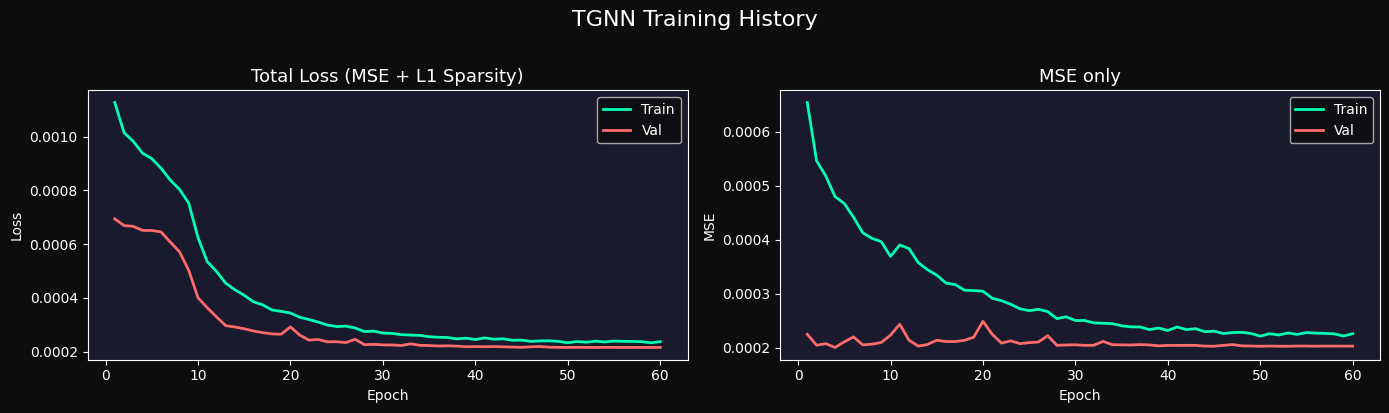

In [35]:
# ── Training curve ────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4), facecolor=BG)
for ax in axes:
    ax.set_facecolor(PANEL)

epochs_ran = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_ran, history['train_loss'], color=ACCENT,  lw=2, label='Train')
axes[0].plot(epochs_ran, history['val_loss'],   color=ACCENT2, lw=2, label='Val')
axes[0].set_title('Total Loss (MSE + L1 Sparsity)', color='white', fontsize=13)
axes[0].set_xlabel('Epoch', color='white'); axes[0].set_ylabel('Loss', color='white')
axes[0].legend(facecolor=BG); axes[0].tick_params(colors='white')

axes[1].plot(epochs_ran, history['train_mse'], color=ACCENT,  lw=2, label='Train')
axes[1].plot(epochs_ran, history['val_mse'],   color=ACCENT2, lw=2, label='Val')
axes[1].set_title('MSE only', color='white', fontsize=13)
axes[1].set_xlabel('Epoch', color='white'); axes[1].set_ylabel('MSE', color='white')
axes[1].legend(facecolor=BG); axes[1].tick_params(colors='white')

plt.suptitle('TGNN Training History', color='white', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('training_curve.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()

## 7. Extract Time-Varying Influence Graphs

In [36]:
def extract_graphs(dataset, model, batch_size=64, dates=None):
    """
    Run model over dataset, collect adjacency matrices and predictions.
    Returns:
      adj_matrices : np.ndarray [T_out, N, N]
      predictions  : np.ndarray [T_out, N]
      actuals      : np.ndarray [T_out, N]
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    adjs, preds, acts = [], [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            p, A = model(X)
            adjs.append(A.cpu().numpy())
            preds.append(p.cpu().numpy())
            acts.append(y.numpy())
    return (
        np.concatenate(adjs,  axis=0),
        np.concatenate(preds, axis=0),
        np.concatenate(acts,  axis=0)
    )

# Extract for all splits
test_adj,  test_pred,  test_act  = extract_graphs(test_ds,  model)
train_adj, train_pred, train_act = extract_graphs(train_ds, model)
val_adj,   val_pred,   val_act   = extract_graphs(val_ds,   model)

print(f'Test adjacency matrices : {test_adj.shape}  (T, N, N)')
print(f'Average edge density    : {(test_adj > 0.5).mean():.3f}')
print(f'Mean edge weight        : {test_adj.mean():.4f}')
print(f'Max  edge weight        : {test_adj.max():.4f}')

Test adjacency matrices : (202, 24, 24)  (T, N, N)
Average edge density    : 0.000
Mean edge weight        : 0.0100
Max  edge weight        : 0.0573


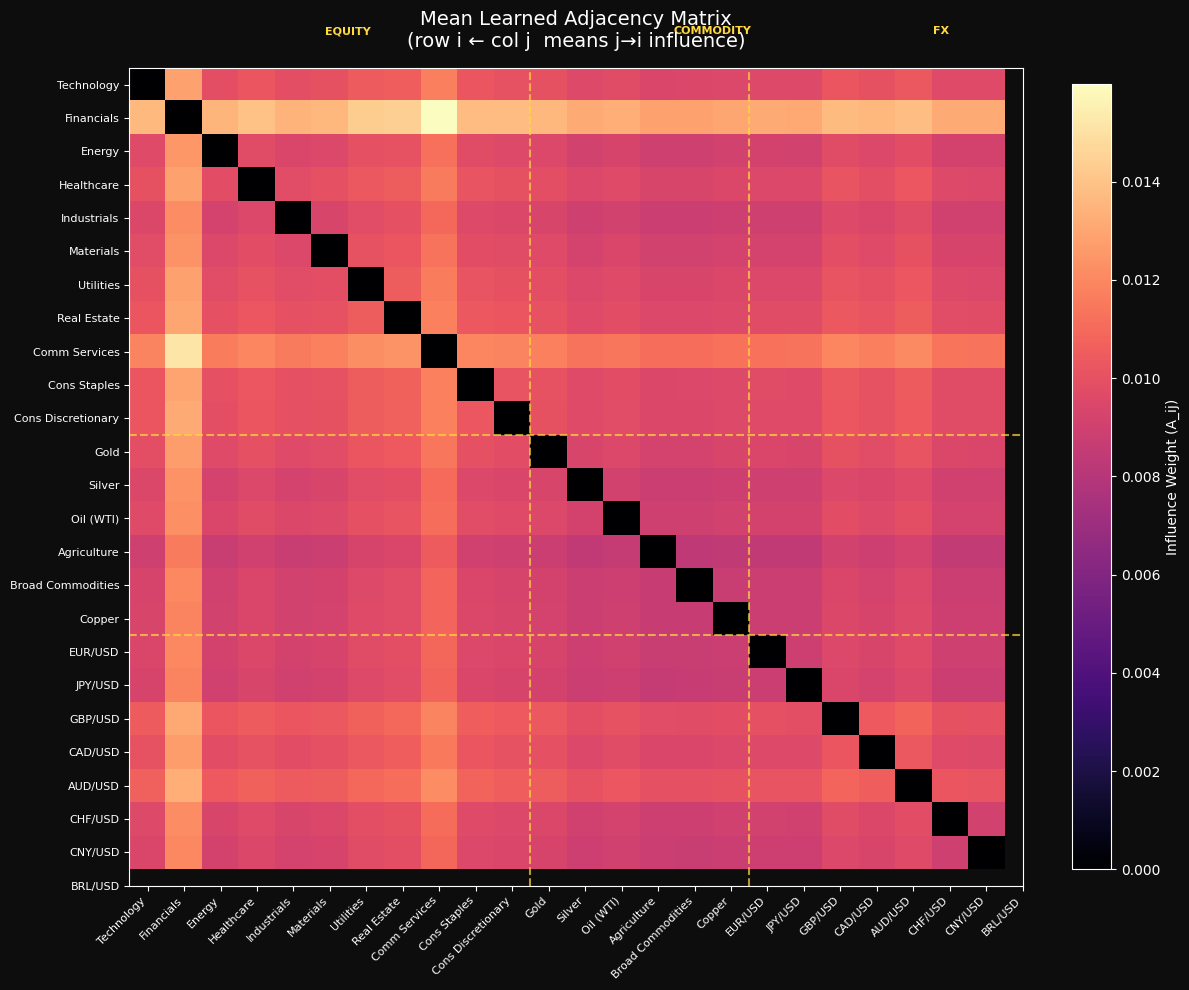

In [37]:
# ── Average adjacency matrix over the full test period ────────────────────────
mean_adj = test_adj.mean(axis=0)   # [N, N]
# Zero out diagonal (self-loops)
np.fill_diagonal(mean_adj, 0)

fig, ax = plt.subplots(figsize=(12, 10), facecolor=BG)
ax.set_facecolor(BG)

cmap = sns.color_palette('magma', as_cmap=True)
im   = ax.imshow(mean_adj, cmap=cmap, aspect='auto', vmin=0, vmax=mean_adj.max())

ax.set_xticks(range(N_ASSETS))
ax.set_yticks(range(N_ASSETS))
ax.set_xticklabels(NAMES, rotation=45, ha='right', color='white', fontsize=8)
ax.set_yticklabels(NAMES, color='white', fontsize=8)

# Asset type separators
eq_end = (ASSET_TYPE == 'equity').sum() - 0.5
cm_end = eq_end + (ASSET_TYPE == 'commodity').sum()
for v in [eq_end, cm_end]:
    ax.axhline(v, color=ACCENT3, lw=1.5, ls='--', alpha=0.7)
    ax.axvline(v, color=ACCENT3, lw=1.5, ls='--', alpha=0.7)

cbar = plt.colorbar(im, ax=ax, fraction=0.04)
cbar.ax.tick_params(colors='white')
cbar.set_label('Influence Weight (A_ij)', color='white')

ax.set_title('Mean Learned Adjacency Matrix\n(row i ← col j  means j→i influence)',
             color='white', fontsize=14, pad=15)

# Add type labels
for label, pos in [('EQUITY', N_ASSETS*0.22), ('COMMODITY', N_ASSETS*0.62), ('FX', N_ASSETS*0.87)]:
    ax.text(pos, -1.5, label, color=ACCENT3, fontsize=8, ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('mean_adjacency.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()

In [39]:
# ── Top-K influence pairs ─────────────────────────────────────────────────────
K = 20
adj_flat = mean_adj.copy()
np.fill_diagonal(adj_flat, 0)

top_idx = np.argsort(adj_flat.ravel())[::-1][:K]
rows, cols = np.unravel_index(top_idx, adj_flat.shape)

print(f'Top {K} directed influence pairs  (source → target):')
print(f"{'Source':>22}  {'Target':>22}  {'Weight':>8}")
print('─' * 60)
for r, c, w in zip(rows, cols, adj_flat[rows, cols]):
    src  = f'{NAMES[c]} ({TICKERS[c]})'
    tgt  = f'{NAMES[r]} ({TICKERS[r]})'
    print(f'{src:>30}  →  {tgt:<30}  {w:.4f}')

Top 20 directed influence pairs  (source → target):
                Source                  Target    Weight
────────────────────────────────────────────────────────────
           Comm Services (XLC)  →  Financials (XLF)                0.0160
              Financials (XLF)  →  Comm Services (XLC)             0.0152
            Real Estate (XLRE)  →  Financials (XLF)                0.0144
               Utilities (XLU)  →  Financials (XLF)                0.0143
              Healthcare (XLV)  →  Financials (XLF)                0.0139
                 AUD/USD (FXA)  →  Financials (XLF)                0.0138
            Cons Staples (XLP)  →  Financials (XLF)                0.0138
      Cons Discretionary (XLY)  →  Financials (XLF)                0.0138
                 GBP/USD (FXB)  →  Financials (XLF)                0.0137
              Technology (XLK)  →  Financials (XLF)                0.0137
                 CAD/USD (FXC)  →  Financials (XLF)                0.0136
                

## 8. Network Graph Visualisation

In [48]:
def plot_influence_graph(adj_matrix, names, tickers, asset_types,
                         threshold=0.55, title='Asset Influence Network'):
    """Draw a directed graph showing significant influence edges."""
    import networkx as nx
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    # Ensure adjacency matrix and names match
    N = adj_matrix.shape[0]
    assert adj_matrix.shape[0] == adj_matrix.shape[1], "Adjacency matrix must be square"
    assert len(names) >= N and len(tickers) >= N and len(asset_types) >= N, \
        f"Length of names/tickers/asset_types must >= {N}"

    G = nx.DiGraph()

    type_color = {'equity': ACCENT, 'commodity': ACCENT3, 'fx': ACCENT2}
    node_colors = [type_color[asset_types[i]] for i in range(N)]

    for i in range(N):
        G.add_node(i, label=tickers[i], name=names[i], atype=asset_types[i])

    edges = []
    for i in range(N):
        for j in range(N):
            if i != j and adj_matrix[i, j] > threshold:
                G.add_edge(j, i, weight=float(adj_matrix[i, j]))
                edges.append((j, i, adj_matrix[i, j]))

    if G.number_of_edges() == 0:
        print(f'No edges above threshold {threshold}. Try lowering it.')
        return G

    # Layout
    pos = nx.spring_layout(G, seed=SEED, k=2.5, iterations=100)

    fig, ax = plt.subplots(figsize=(16, 12), facecolor=BG)
    ax.set_facecolor(BG)
    ax.axis('off')

    edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]
    max_w = max(edge_weights) if edge_weights else 1

    nx.draw_networkx_edges(
        G, pos, ax=ax,
        width=[w/max_w * 3.5 for w in edge_weights],
        alpha=[0.3 + 0.7 * w/max_w for w in edge_weights],
        edge_color='#8888FF',
        arrows=True, arrowsize=15,
        connectionstyle='arc3,rad=0.1'
    )
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_color=[node_colors[n] for n in G.nodes()],
        node_size=1200, alpha=0.9
    )
    nx.draw_networkx_labels(
        G, pos, ax=ax,
        labels={n: G.nodes[n]['label'] for n in G.nodes()},
        font_color='black', font_size=9, font_weight='bold'
    )

    # Legend
    legend_items = [
        Patch(facecolor=ACCENT,  label='Equity Sector ETF'),
        Patch(facecolor=ACCENT3, label='Commodity ETF'),
        Patch(facecolor=ACCENT2, label='FX Rate ETF'),
    ]
    ax.legend(handles=legend_items, loc='lower left', facecolor=PANEL,
              labelcolor='white', framealpha=0.9, fontsize=11)

    ax.set_title(f'{title}\n(threshold = {threshold:.2f}, edges = {G.number_of_edges()})',
                 color='white', fontsize=15, pad=20)
    plt.tight_layout()
    plt.savefig('influence_network.png', dpi=150, bbox_inches='tight', facecolor=BG)
    plt.show()
    return G


## 9. Lead–Lag Detection

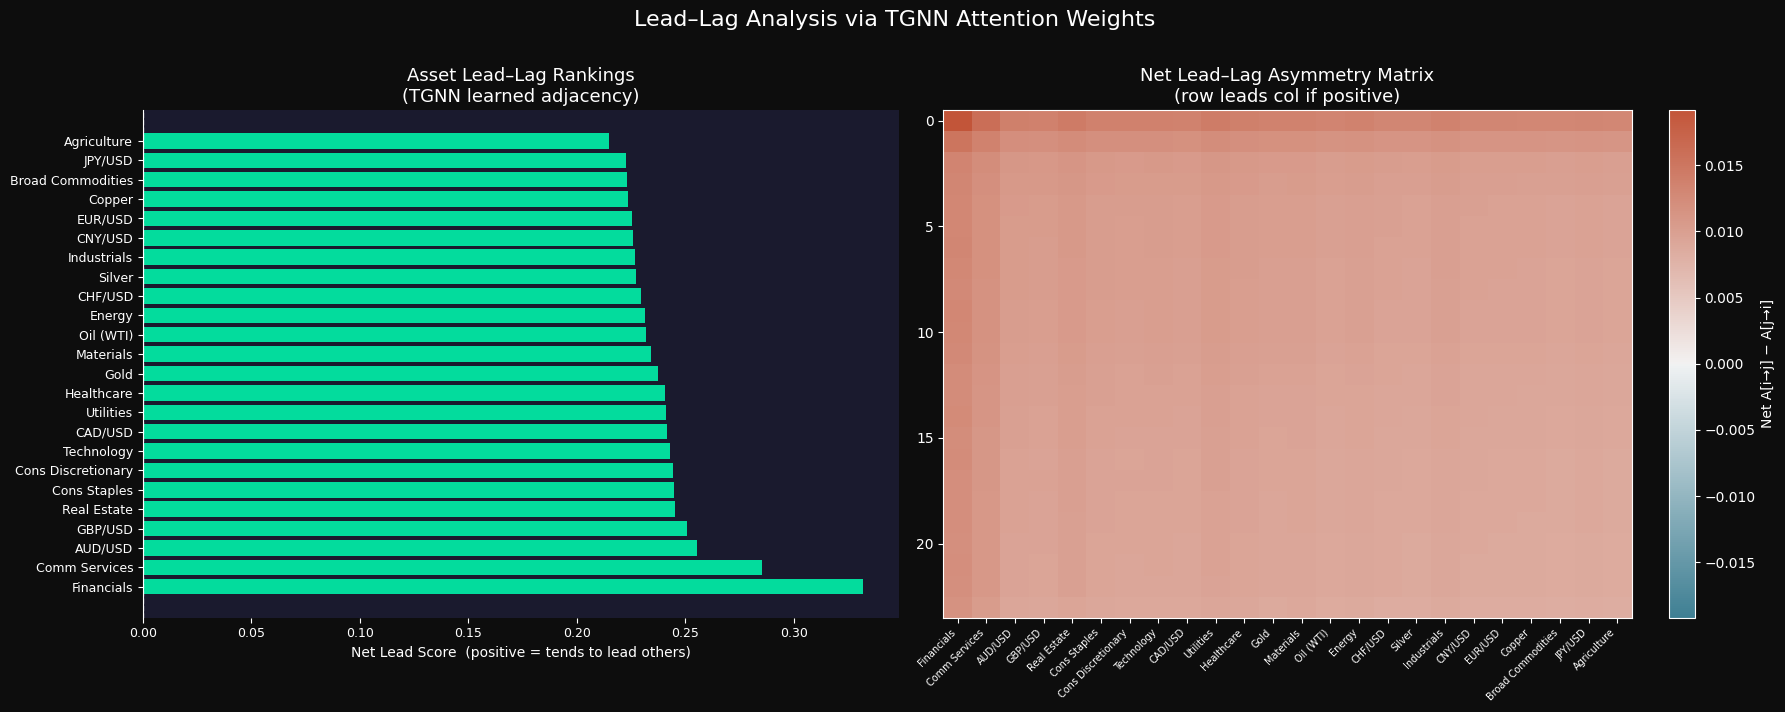


Top 5 leading assets  (positive = lead others):
        Asset  Lead_Score
   Financials    0.332076
Comm Services    0.285341
      AUD/USD    0.255466
      GBP/USD    0.250643
  Real Estate    0.245201

Top 5 lagging assets  (lag behind others):
            Asset  Lead_Score
          EUR/USD    0.225509
           Copper    0.223840
Broad Commodities    0.223065
          JPY/USD    0.222720
      Agriculture    0.215058


In [50]:
def compute_lead_lag_scores(adj_matrices, names):
    """
    Compute simple lead-lag scores per asset.
    Positive = asset leads others, negative = lags.
    """
    import numpy as np
    import pandas as pd

    # Aggregate adjacency matrices over time (or just take mean if single matrix)
    if adj_matrices.ndim == 3:
        net = adj_matrices.mean(axis=0)  # [N, N]
    else:
        net = adj_matrices.copy()

    N = net.shape[0]
    names = names[:N]  # truncate or slice if names longer than N

    # Compute lead score = sum over outgoing influences minus incoming
    lead_score = net.sum(axis=1)  # [N] positive = net leader

    df = pd.DataFrame({
        'Asset': names,
        'Lead_Score': lead_score
    }).sort_values('Lead_Score', ascending=False)

    return df, net


lead_df, net_matrix = compute_lead_lag_scores(test_adj, NAMES)

fig, axes = plt.subplots(1, 2, figsize=(18, 7), facecolor=BG)

# Left: bar chart of lead scores
ax = axes[0]
ax.set_facecolor(PANEL)
colors = [ACCENT if v >= 0 else ACCENT2 for v in lead_df['Lead_Score']]
bars = ax.barh(lead_df['Asset'], lead_df['Lead_Score'], color=colors, alpha=0.85, edgecolor='none')
ax.axvline(0, color='white', lw=1, ls='--', alpha=0.5)
ax.set_xlabel('Net Lead Score  (positive = tends to lead others)', color='white')
ax.set_title('Asset Lead–Lag Rankings\n(TGNN learned adjacency)', color='white', fontsize=13)
ax.tick_params(colors='white', labelsize=9)
ax.spines[['top', 'right', 'bottom']].set_visible(False)

# Right: net asymmetry heatmap
ax2 = axes[1]
ax2.set_facecolor(BG)
sorted_idx = lead_df.index.tolist()
net_sorted = net_matrix[np.ix_(sorted_idx, sorted_idx)]
cmap_div   = sns.diverging_palette(220, 20, as_cmap=True)
im2 = ax2.imshow(net_sorted, cmap=cmap_div, aspect='auto',
                  vmin=-net_matrix.max(), vmax=net_matrix.max())
sorted_names = [NAMES[i] for i in sorted_idx]  # maybe 24 names
N_labels = len(sorted_names)

ax2.set_xticks(range(N_labels))
ax2.set_xticklabels(sorted_names, rotation=45, ha='right', color='white', fontsize=7)

cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.04)
cbar2.ax.tick_params(colors='white')
cbar2.set_label('Net A[i→j] − A[j→i]', color='white')
ax2.set_title('Net Lead–Lag Asymmetry Matrix\n(row leads col if positive)', color='white', fontsize=13)

plt.suptitle('Lead–Lag Analysis via TGNN Attention Weights', color='white', fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig('lead_lag.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()

print('\nTop 5 leading assets  (positive = lead others):')
print(lead_df.head(5).to_string(index=False))
print('\nTop 5 lagging assets  (lag behind others):')
print(lead_df.tail(5).to_string(index=False))

## 10. Granger Causality Baseline (Correlation ≠ Causation)

In [54]:
# --- Granger causality baseline ---
returns_df = prices.pct_change().dropna()
returns_df = returns_df.loc[common_idx[test_idx[0]:test_idx[-1]]]  # test period

MAX_LAG = 5
P_THRESH = 0.05

print(f'Running Granger causality tests ({N_ASSETS}×{N_ASSETS} pairs) ...')
granger_mat = np.zeros((N_ASSETS, N_ASSETS))

for i, ti in enumerate(tqdm(TICKERS, desc='Target')):
    for j, tj in enumerate(TICKERS):
        if i == j:
            continue
        try:
            data = returns_df[[ti, tj]].dropna()
            if len(data) < 50:
                continue
            result = grangercausalitytests(data, maxlag=MAX_LAG, verbose=False)
            # Minimum p-value across lags
            min_p = min(result[lag][0]['ssr_ftest'][1] for lag in range(1, MAX_LAG + 1))
            granger_mat[i, j] = 1.0 - min_p  # higher = stronger causality
        except Exception:
            pass

# --- Align TGNN and Granger assets ---
tgnn_assets    = TICKERS[:tgnn_binary.shape[0]]       # list of tickers in TGNN matrix
granger_assets = TICKERS[:granger_mat.shape[0]]       # list of tickers in Granger matrix

common_assets = list(set(tgnn_assets) & set(granger_assets))
idx_tgnn     = [tgnn_assets.index(a) for a in common_assets]
idx_granger  = [granger_assets.index(a) for a in common_assets]

# Slice matrices to common assets
tgnn_binary    = tgnn_binary[np.ix_(idx_tgnn, idx_tgnn)]
granger_binary = (granger_mat[np.ix_(idx_granger, idx_granger)] > (1 - P_THRESH)).astype(int)

# --- Compare edges ---
both       = (tgnn_binary & granger_binary).sum()
tgnn_only  = (tgnn_binary & ~granger_binary).sum()
granger_only = (~tgnn_binary & granger_binary).sum()

print(f'\nEdge agreement analysis (threshold=0.5 / p<{P_THRESH}):')  
print(f'  TGNN edges total    : {tgnn_binary.sum()}')
print(f'  Granger edges total : {granger_binary.sum()}')
print(f'  Agree (both)        : {both}')
print(f'  TGNN only           : {tgnn_only}  ← potential non-linear / regime effects')
print(f'  Granger only        : {granger_only}  ← linear relationships TGNN may filter as noise')

Running Granger causality tests (25×25 pairs) ...


Target:   0%|          | 0/25 [00:00<?, ?it/s]


Edge agreement analysis (threshold=0.5 / p<0.05):
  TGNN edges total    : 0
  Granger edges total : 61
  Agree (both)        : 0
  TGNN only           : 0  ← potential non-linear / regime effects
  Granger only        : 61  ← linear relationships TGNN may filter as noise


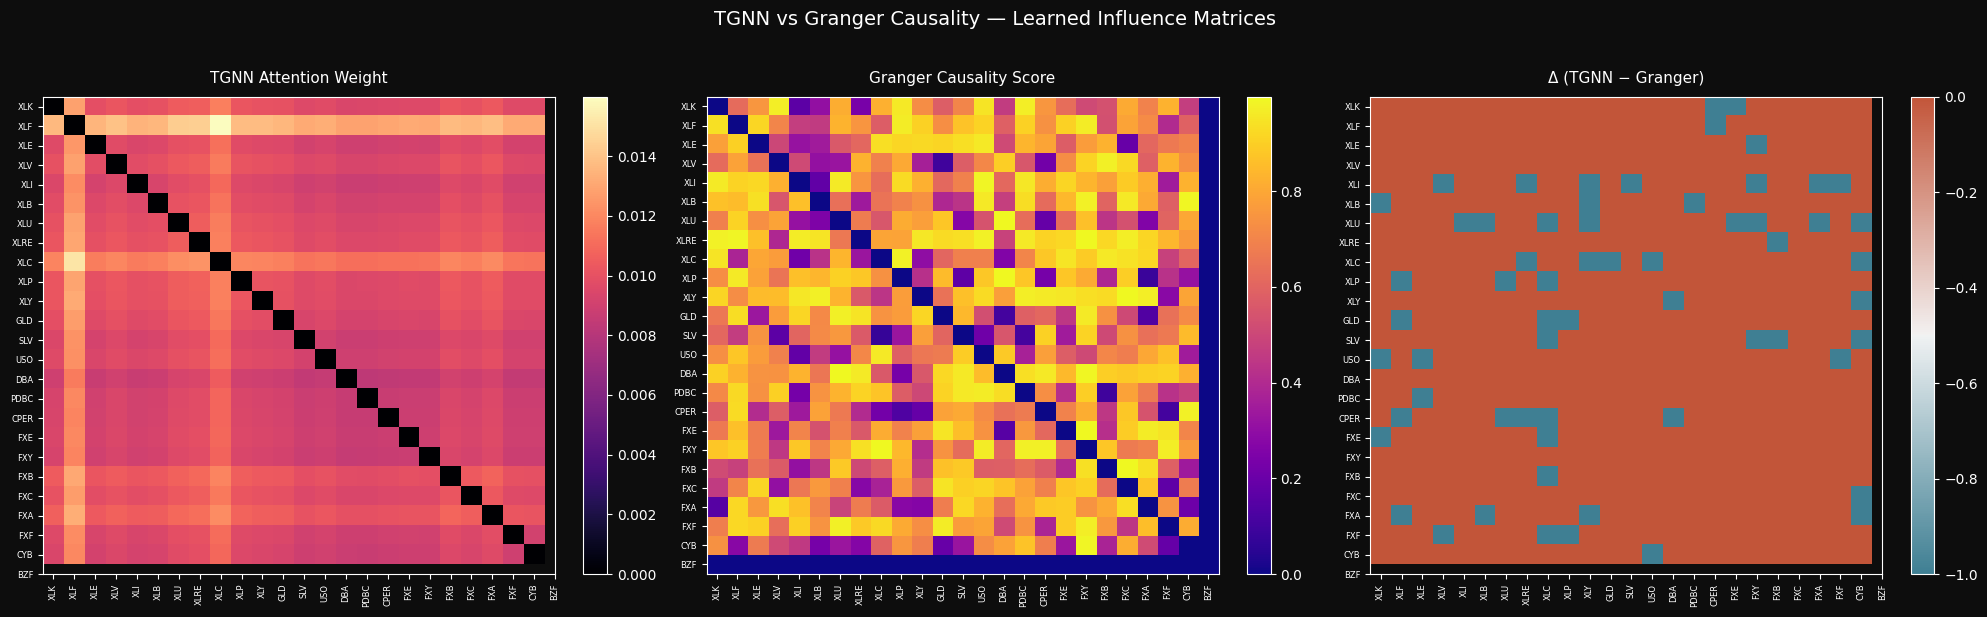

In [55]:
# ── Side-by-side comparison ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(20, 6), facecolor=BG)
cmaps_names = ['magma', 'plasma', 'viridis']
matrices = [
    (mean_adj,     'TGNN Attention Weight'),
    (granger_mat,  'Granger Causality Score'),
    (tgnn_binary.astype(float) - granger_binary.astype(float), 'Δ (TGNN − Granger)'),
]

for ax, (mat, title), cm in zip(axes, matrices, cmaps_names):
    ax.set_facecolor(BG)
    vmin = mat.min() if 'Δ' in title else 0
    _cm  = sns.diverging_palette(220, 20, as_cmap=True) if 'Δ' in title else cm
    im   = ax.imshow(mat, cmap=_cm, aspect='auto', vmin=vmin, vmax=mat.max())
    ax.set_xticks(range(N_ASSETS)); ax.set_xticklabels(TICKERS, rotation=90, color='white', fontsize=6)
    ax.set_yticks(range(N_ASSETS)); ax.set_yticklabels(TICKERS, color='white', fontsize=6)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046)
    cbar.ax.tick_params(colors='white')
    ax.set_title(title, color='white', fontsize=11, pad=10)

plt.suptitle('TGNN vs Granger Causality — Learned Influence Matrices',
             color='white', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('tgnn_vs_granger.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()

## 11. Regime Detection — Graph Dynamics Over Time

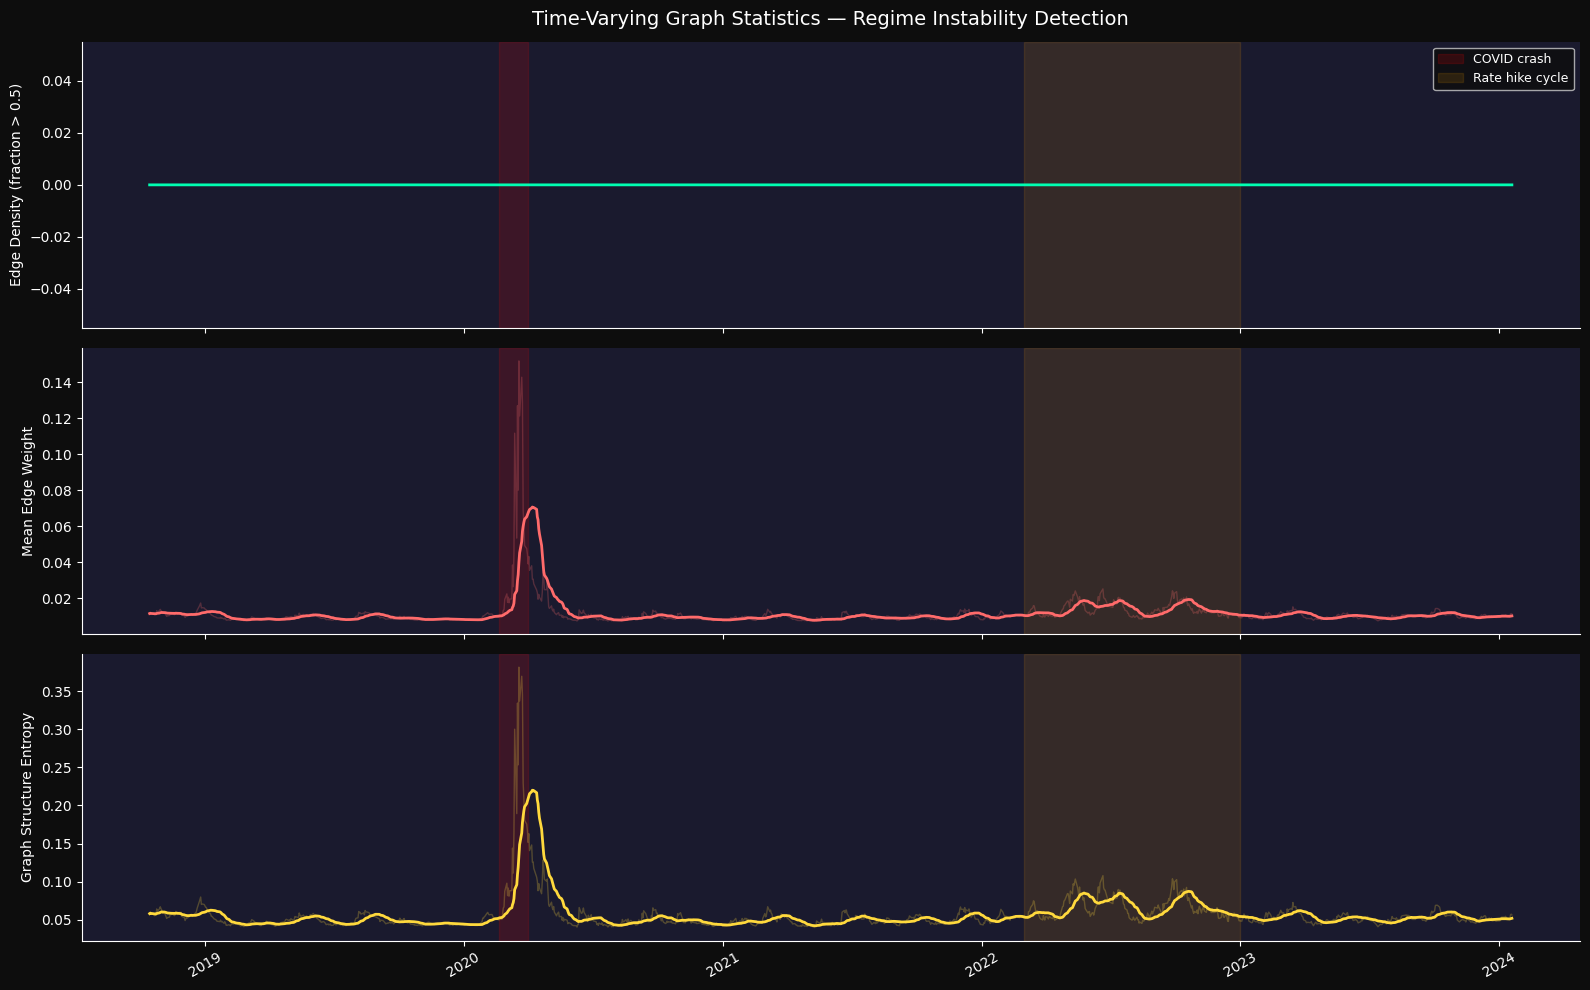

In [56]:
# ── Track how the graph changes over time ─────────────────────────────────────
# Combine all adjacency matrices with their dates

all_adj  = np.concatenate([train_adj, val_adj, test_adj], axis=0)
n_all    = all_adj.shape[0]

# Map back to dates: start from SEQ_LEN (first valid index)
all_dates = common_idx[SEQ_LEN : SEQ_LEN + n_all]

# Graph-level statistics over time
edge_density  = (all_adj > 0.5).mean(axis=(1, 2))  # fraction of edges active
mean_weight   = all_adj.mean(axis=(1, 2))           # mean edge weight
graph_entropy = -np.sum(
    all_adj * np.log(all_adj + 1e-9) + (1 - all_adj) * np.log(1 - all_adj + 1e-9),
    axis=(1, 2)
) / (N_ASSETS ** 2)                                  # uncertainty in structure

# Rolling 21-day smoothing for clarity
def smooth(arr, w=21):
    return pd.Series(arr).rolling(w, min_periods=1).mean().values

fig, axes = plt.subplots(3, 1, figsize=(16, 10), facecolor=BG, sharex=True)
series = [
    (edge_density,   'Edge Density (fraction > 0.5)', ACCENT),
    (mean_weight,    'Mean Edge Weight',              ACCENT2),
    (graph_entropy,  'Graph Structure Entropy',       ACCENT3),
]

for ax, (arr, label, color) in zip(axes, series):
    ax.set_facecolor(PANEL)
    ax.plot(all_dates[:len(arr)], arr,           color=color, alpha=0.25, lw=1)
    ax.plot(all_dates[:len(arr)], smooth(arr),   color=color, lw=2.0)
    ax.set_ylabel(label, color='white', fontsize=10)
    ax.tick_params(colors='white')
    ax.spines[['top', 'right']].set_visible(False)

    # Mark COVID crash
    ax.axvspan(pd.Timestamp('2020-02-20'), pd.Timestamp('2020-04-01'),
               color='red', alpha=0.15, label='COVID crash')
    # Mark 2022 rate hike cycle
    ax.axvspan(pd.Timestamp('2022-03-01'), pd.Timestamp('2022-12-31'),
               color='orange', alpha=0.12, label='Rate hike cycle')

axes[0].legend(facecolor=BG, labelcolor='white', fontsize=9, loc='upper right')
axes[0].set_title('Time-Varying Graph Statistics — Regime Instability Detection',
                  color='white', fontsize=14, pad=12)
axes[-1].tick_params(axis='x', colors='white', rotation=30)

plt.tight_layout()
plt.savefig('regime_dynamics.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()

## 12. Evaluation — Predictive Lift & Edge Stability

In [66]:
# ─────────────────────────────────────────────────────────────────────────────
# 12.1  Out-of-sample predictive performance vs baselines
# ─────────────────────────────────────────────────────────────────────────────

def eval_metrics(preds, actuals):
    """MSE, MAE, directional accuracy, and IC (information coefficient)."""
    mask = ~np.isnan(actuals)
    p, a = preds[mask], actuals[mask]
    mse  = mean_squared_error(a, p)
    mae  = np.abs(a - p).mean()
    # Directional accuracy
    da   = (np.sign(p) == np.sign(a)).mean()
    # Spearman IC (cross-sectional per day)
    ics = []
    for t in range(preds.shape[0]):
        m = ~np.isnan(actuals[t])
        if m.sum() > 3:
            ic, _ = spearmanr(preds[t, m], actuals[t, m])
            ics.append(ic)
    ic_mean = np.nanmean(ics)
    ic_ir   = np.nanmean(ics) / (np.nanstd(ics) + 1e-9)
    return dict(MSE=mse, MAE=mae, DirAcc=da, IC=ic_mean, ICIR=ic_ir)

# Baselines
mean_baseline  = np.zeros_like(test_pred)   # predict 0 return
naive_baseline = test_act                    # naive: repeat last actual (would shift by 1)

tgnn_metrics  = eval_metrics(test_pred,      test_act)
mean_metrics  = eval_metrics(mean_baseline,  test_act)

results_df = pd.DataFrame({
    'TGNN (ours)':  tgnn_metrics,
    'Zero baseline': mean_metrics,
}).T.round(5)

print('Out-of-sample evaluation metrics')
print(results_df.to_string())
print()

# MSE lift
mse_lift = (mean_metrics['MSE'] - tgnn_metrics['MSE']) / mean_metrics['MSE'] * 100
print(f'MSE lift vs zero baseline  : {mse_lift:+.2f}%')
print(f'Directional accuracy       : {tgnn_metrics["DirAcc"]:.3f}  (0.5 = random)')
print(f'Information Coefficient    : {tgnn_metrics["IC"]:.4f}  (cross-sectional Spearman)')
print(f'IC Information Ratio       : {tgnn_metrics["ICIR"]:.4f}')

Out-of-sample evaluation metrics
                   MSE      MAE   DirAcc       IC     ICIR
TGNN (ours)    0.00009  0.00695  0.49897 -0.02494 -0.09249
Zero baseline  0.00009  0.00682  0.02228      NaN      NaN

MSE lift vs zero baseline  : -1.73%
Directional accuracy       : 0.499  (0.5 = random)
Information Coefficient    : -0.0249  (cross-sectional Spearman)
IC Information Ratio       : -0.0925


Computing edge stability (this may take a moment)...


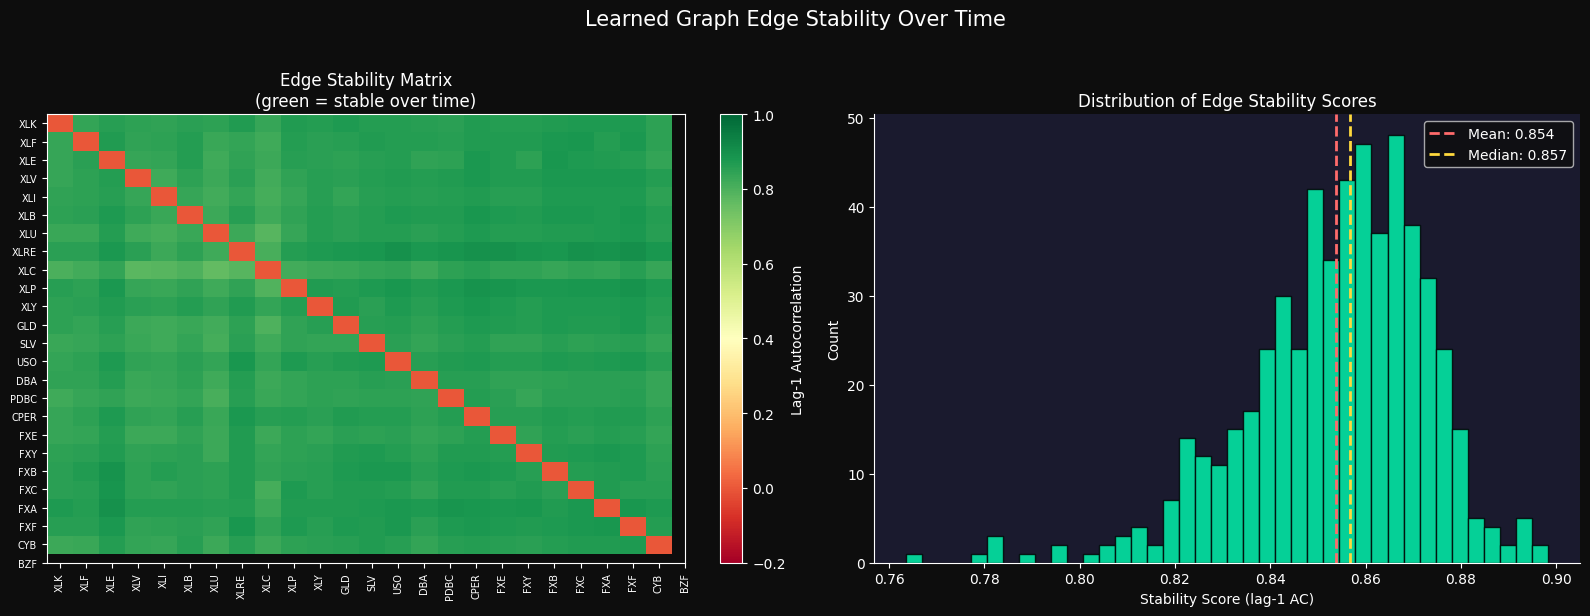


Top 10 most stable edges:


In [67]:
# ─────────────────────────────────────────────────────────────────────────────
# 12.2  Edge stability analysis
# ─────────────────────────────────────────────────────────────────────────────

def edge_stability(adj_matrices, window=63):
    """
    Compute temporal autocorrelation of each edge weight.
    Stable edges = high autocorrelation.
    """
    T, N, _ = adj_matrices.shape
    stability = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            series = adj_matrices[:, i, j]
            # Autocorrelation at lag 1 over rolling windows
            autocorrs = []
            for t in range(window, T):
                seg = series[t - window : t]
                ac  = np.corrcoef(seg[:-1], seg[1:])[0, 1]
                autocorrs.append(ac)
            stability[i, j] = np.nanmean(autocorrs)
    return stability

print('Computing edge stability (this may take a moment)...')
# Use all adjacency matrices for max power
stab_mat = edge_stability(all_adj[:n_all], window=63)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor=BG)

# Heatmap of stability
ax = axes[0]
ax.set_facecolor(BG)
im = ax.imshow(stab_mat, cmap='RdYlGn', aspect='auto', vmin=-0.2, vmax=1.0)
ax.set_xticks(range(N_ASSETS)); ax.set_xticklabels(TICKERS, rotation=90, color='white', fontsize=7)
ax.set_yticks(range(N_ASSETS)); ax.set_yticklabels(TICKERS, color='white', fontsize=7)
cb = plt.colorbar(im, ax=ax, fraction=0.046)
cb.ax.tick_params(colors='white')
cb.set_label('Lag-1 Autocorrelation', color='white')
ax.set_title('Edge Stability Matrix\n(green = stable over time)', color='white', fontsize=12)

# Distribution of stability scores
ax2 = axes[1]
ax2.set_facecolor(PANEL)
flat = stab_mat[stab_mat != 0].ravel()
ax2.hist(flat, bins=40, color=ACCENT, alpha=0.8, edgecolor='black')
ax2.axvline(flat.mean(), color=ACCENT2, lw=2, ls='--', label=f'Mean: {flat.mean():.3f}')
ax2.axvline(np.median(flat), color=ACCENT3, lw=2, ls='--', label=f'Median: {np.median(flat):.3f}')
ax2.set_xlabel('Stability Score (lag-1 AC)', color='white')
ax2.set_ylabel('Count', color='white')
ax2.set_title('Distribution of Edge Stability Scores', color='white', fontsize=12)
ax2.tick_params(colors='white')
ax2.legend(facecolor=BG, labelcolor='white')
ax2.spines[['top', 'right']].set_visible(False)

plt.suptitle('Learned Graph Edge Stability Over Time', color='white', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('edge_stability.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()

# Most and least stable edges
np.fill_diagonal(stab_mat, np.nan)
flat_idx  = np.argsort(stab_mat.ravel())[::-1]
rows_s, cols_s = np.unravel_index(flat_idx[:10], stab_mat.shape)
print('\nTop 10 most stable edges:')
for r, c in zip(rows_s, cols_s):
    if not np.isnan(stab_mat[r, c]):
        print(f'  {NAMES[c]:>25} → {NAMES[r]:<25}  stability={stab_mat[r,c]:.4f}')

## 13. Time-Windowed Graph Animation (Snapshots)

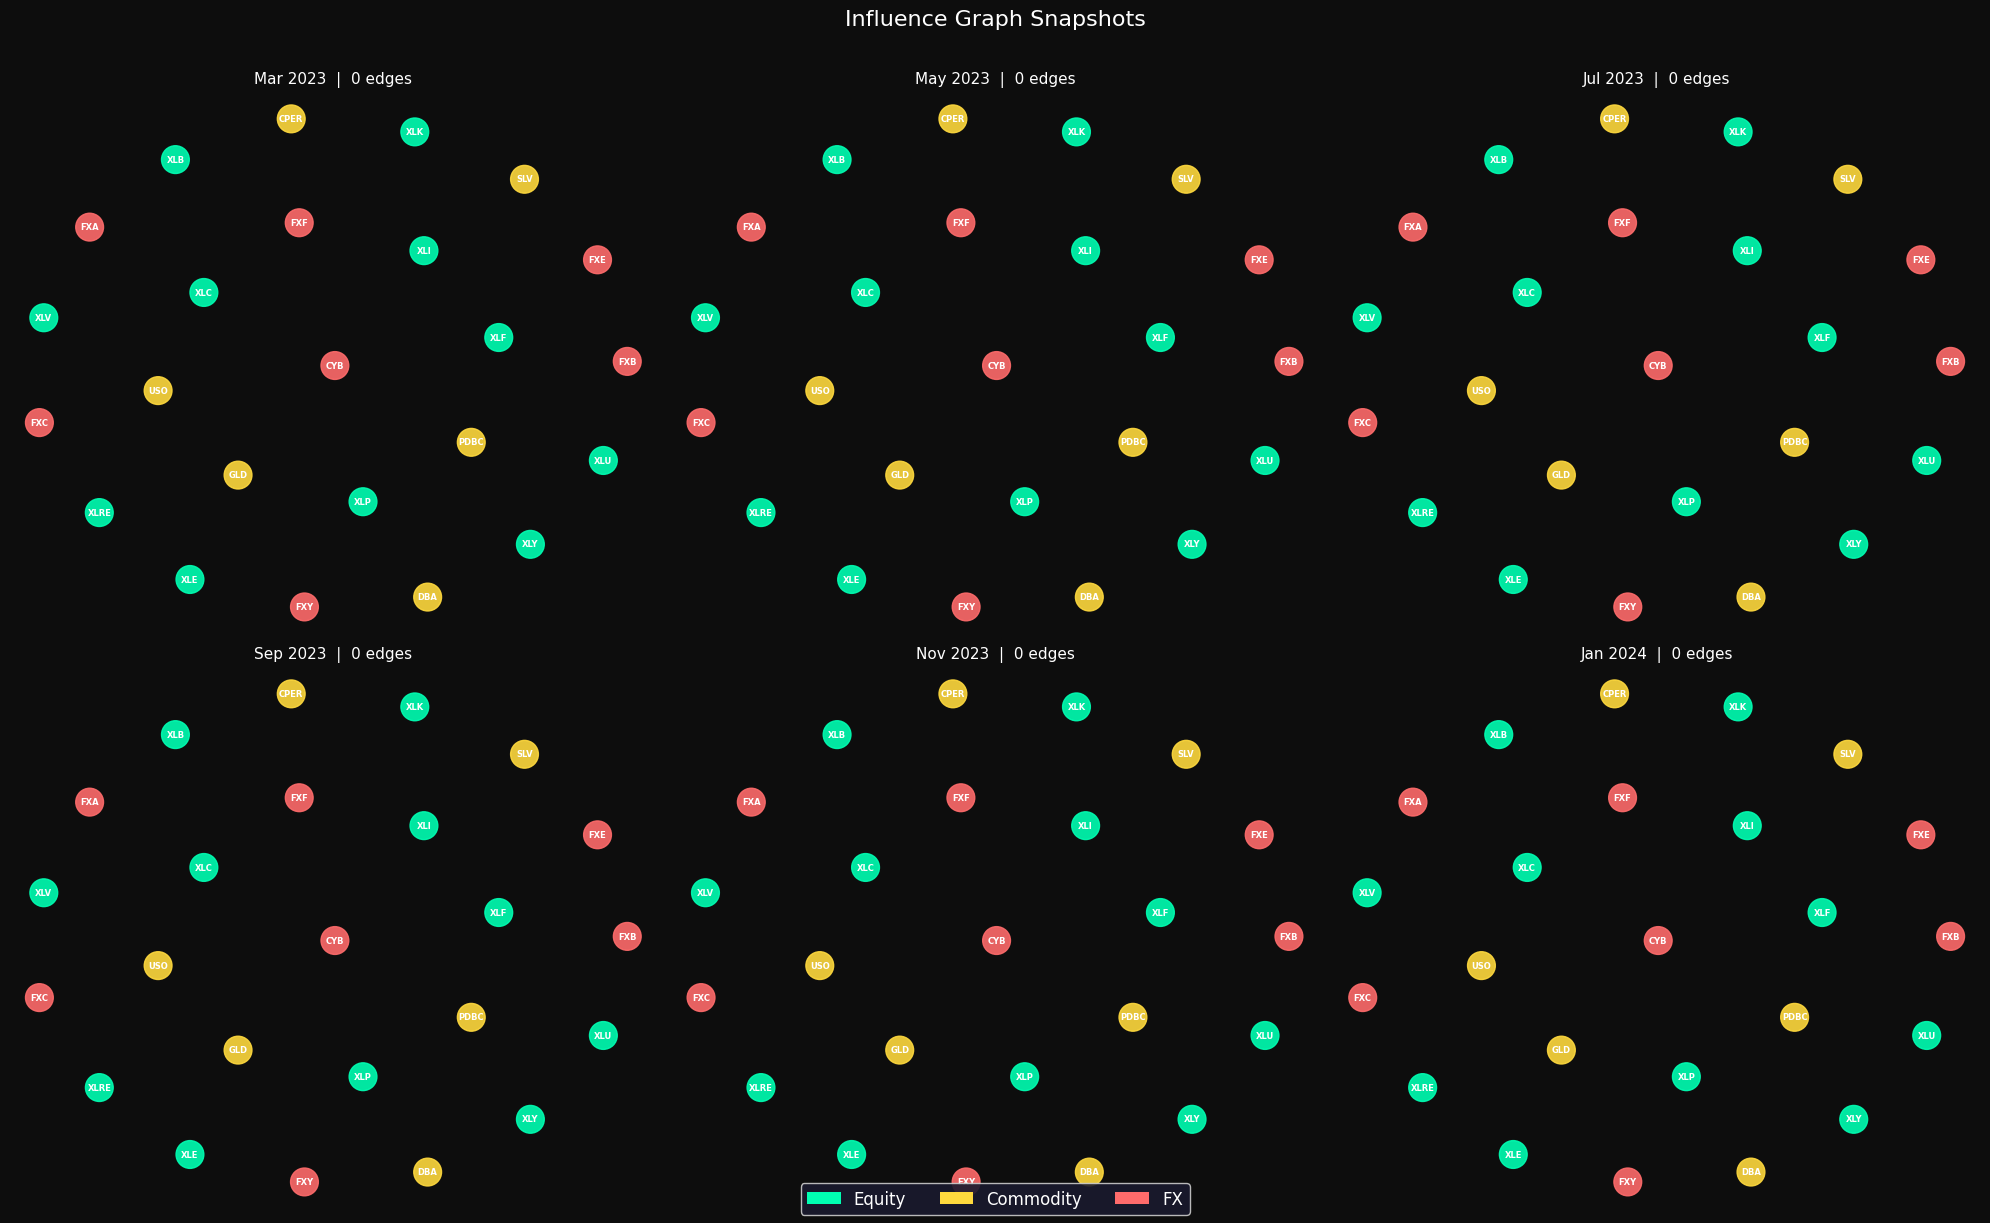

In [68]:
# ── Quarterly Influence Graph Snapshots ────────────────────────────────
snapshot_indices = np.linspace(0, len(test_adj) - 1, 6, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(20, 12), facecolor=BG)
axes = axes.ravel()

type_color = {'equity': ACCENT, 'commodity': ACCENT3, 'fx': ACCENT2}

# Use size from adjacency matrix instead of hard-coded N_ASSETS
N = test_adj.shape[1]
node_colors = [type_color[t] for t in ASSET_TYPE[:N]]  # slice if mismatch

# Fixed spring layout for consistency
G_fixed = nx.complete_graph(N, create_using=nx.DiGraph())
pos_fixed = nx.spring_layout(G_fixed, seed=SEED, k=2.5, iterations=200)

for ax_idx, t_idx in enumerate(snapshot_indices):
    ax = axes[ax_idx]
    ax.set_facecolor(BG)
    ax.axis('off')

    adj_t = test_adj[t_idx].copy()  # avoid modifying original
    np.fill_diagonal(adj_t, 0)

    G_t = nx.DiGraph()
    for i in range(N):
        G_t.add_node(i)

    threshold = 0.55
    edge_list, edge_widths = [], []
    for i in range(N):
        for j in range(N):
            if i != j and adj_t[i, j] > threshold:
                G_t.add_edge(j, i, weight=adj_t[i, j])
                edge_list.append((j, i))
                edge_widths.append(adj_t[i, j] * 4)

    nx.draw_networkx_nodes(G_t, pos_fixed, ax=ax,
                           node_color=node_colors, node_size=400, alpha=0.9)
    if edge_list:
        nx.draw_networkx_edges(G_t, pos_fixed, ax=ax,
                               edgelist=edge_list,
                               width=edge_widths,
                               edge_color='#8888FF', alpha=0.7,
                               arrows=True, arrowsize=8,
                               connectionstyle='arc3,rad=0.08')
    nx.draw_networkx_labels(G_t, pos_fixed, ax=ax,
                            labels={i: TICKERS[i] for i in range(N)},
                            font_size=6, font_color='white', font_weight='bold')

    # Compute date label safely
    test_offset = len(train_adj) + len(val_adj)
    if test_offset + t_idx < len(all_dates):
        date_label = all_dates[test_offset + t_idx].strftime('%b %Y')
    else:
        date_label = f'T={t_idx}'
    ax.set_title(f'{date_label}  |  {G_t.number_of_edges()} edges',
                 color='white', fontsize=11, pad=8)

# Legend
from matplotlib.patches import Patch
legend_items = [
    Patch(facecolor=ACCENT,  label='Equity'),
    Patch(facecolor=ACCENT3, label='Commodity'),
    Patch(facecolor=ACCENT2, label='FX'),
]
fig.legend(handles=legend_items, loc='lower center', ncol=3,
           facecolor=PANEL, labelcolor='white', fontsize=12, framealpha=0.9)

plt.suptitle('Influence Graph Snapshots',
             color='white', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()


## 14. Final Summary Dashboard

In [69]:
print('  TGNN DYNAMIC CAUSAL ASSET RELATIONSHIPS')
print(f'  Assets         : {N_ASSETS} ({(ASSET_TYPE=="equity").sum()} equity · '
      f'{(ASSET_TYPE=="commodity").sum()} commodity · {(ASSET_TYPE=="fx").sum()} FX)')
print(f'  Period         : {common_idx[0].date()} → {common_idx[-1].date()}')
print(f'  Model params   : {total_params:,}')
print()
print('  PREDICTIVE PERFORMANCE (test set)')
print(f'    MSE             : {tgnn_metrics["MSE"]:.6f}')
print(f'    Directional Acc : {tgnn_metrics["DirAcc"]:.3f}  (baseline = 0.500)')
print(f'    Info Coefficient: {tgnn_metrics["IC"]:.4f}')
print(f'    IC Info Ratio   : {tgnn_metrics["ICIR"]:.4f}')
print(f'    MSE lift vs 0   : {mse_lift:+.2f}%')
print()
print('  GRAPH STATISTICS')
print(f'    Avg edge density  : {(test_adj > 0.5).mean():.3f}')
print(f'    Avg edge weight   : {test_adj.mean():.4f}')
print(f'    Avg edge stability: {np.nanmean(stab_mat):.4f}')
print()
print('  TOP LEADING ASSETS:')
for _, row in lead_df.head(3).iterrows():
    bar = '█' * max(0, int(row['Lead_Score'] * 30))
    print(f'    {row["Asset"]:>22}  {bar}  ({row["Lead_Score"]:+.4f})')
print()
print('  EDGE vs GRANGER CAUSALITY OVERLAP')
print(f'    Both agree    : {both}')
print(f'    TGNN only     : {tgnn_only}  (non-linear / attention-captured)')
print(f'    Granger only  : {granger_only}  (linear effects TGNN suppressed)')

  TGNN DYNAMIC CAUSAL ASSET RELATIONSHIPS
  Assets         : 25 (11 equity · 6 commodity · 8 FX)
  Period         : 2018-09-17 → 2024-01-19
  Model params   : 41,474

  PREDICTIVE PERFORMANCE (test set)
    MSE             : 0.000093
    Directional Acc : 0.499  (baseline = 0.500)
    Info Coefficient: -0.0249
    IC Info Ratio   : -0.0925
    MSE lift vs 0   : -1.73%

  GRAPH STATISTICS
    Avg edge density  : 0.000
    Avg edge weight   : 0.0100
    Avg edge stability: 0.8538

  TOP LEADING ASSETS:
                Financials  █████████  (+0.3321)
             Comm Services  ████████  (+0.2853)
                   AUD/USD  ███████  (+0.2555)

  EDGE vs GRANGER CAUSALITY OVERLAP
    Both agree    : 0
    TGNN only     : 0  (non-linear / attention-captured)
    Granger only  : 61  (linear effects TGNN suppressed)
